# Implementing Vision Transformer with Flax NNX

* **With transfer learning of the original ViT model in HF**

## The ViT architecture

A Vision Transformer (ViT) treats images as sequences of patches and leverages the attention mechanism from transformers. The architecture consists of the following key components:

- **Patch and position embedding:** Breaking down an image into fixed-size patches and embedding each patch into a vector representation. Positional embeddings are added to encode the position of each patch within the original image, which aids with spatial information.
- **Transformer encoder:** A stack of transformer encoder blocks processes the input embedded patches. Each block consists of:
  - **Multi-Head (Self-)Attention:** This allows the model to weigh the importance of different patches relative to each other, capturing relationships within the image.
  - **Feed-forward network:** Processes each patch independently, allowing a for non-linear transformations.
  - **Layer normatlization and residual connections:** Stabilize training and improve gradient flow in the network.
- **Classification head:** The output of the transformer encoder is fed into a linear layer and then a softmax function, resulting in class probabilities for prediction.

![ViT-architecture](https://github.com/google-research/vision_transformer/raw/main/vit_figure.png)

**Note:** The original JAX-based implementation of a ViT can also be found in the [`google-research` GitHub repo](https://github.com/google-research/vision_transformer/).

In [1]:
!pip install -q grain


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax

In [4]:
print(f"Devices: {jax.devices()}")

E0000 00:00:1747867368.081037      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


## Defining the model with Flax NNX

In [5]:
class VisionTransformer(nnx.Module):
    """ Implements the ViT model, inheriting from `flax.nnx.Module`.

    Args:
        num_classes (int): Number of classes in the classification. Defaults to 1000.
        in_channels (int): Number of input channels in the image (such as 3 for RGB). Defaults to 3.
        img_size (int): Input image size. Defaults to 224.
        patch_size (int): Size of the patches extracted from the image. Defaults to 16.
        num_layers (int): Number of transformer encoder layers. Defaults to 12.
        num_heads (int): Number of attention heads in each transformer layer. Defaults to 12.
        mlp_dim (int): Dimension of the hidden layers in the feed-forward/MLP block. Defaults to 3072.
        hidden_size (int): Dimensionality of the embedding vectors. Defaults to 3072.
        dropout_rate (int): Dropout rate (for regularization). Defaults to 0.1.
        rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX pseudo-random number generator (PRNG) keys. Defaults to `flax.nnx.Rngs(0)`.

    """
    def __init__(
        self,
        num_classes: int = 1000,
        in_channels: int = 3,
        img_size: int = 224,
        patch_size: int = 16,
        num_layers: int = 12,
        num_heads: int = 12,
        mlp_dim: int = 3072,
        hidden_size: int = 768,
        dropout_rate: float = 0.1,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        # Calculate the number of patches generated from the image.
        n_patches = (img_size // patch_size) ** 2
        # Patch embeddings:
        # - Extracts patches from the input image and maps them to embedding vectors
        #   using `flax.nnx.Conv` (convolutional layer).
        self.patch_embeddings = nnx.Conv(
            in_channels,
            hidden_size,
            kernel_size=(patch_size, patch_size),
            strides=(patch_size, patch_size),
            padding="VALID",
            use_bias=True,
            rngs=rngs,
        )

        # Positional embeddings (add information about image patch positions):
        # Set the truncated normal initializer (using `jax.nn.initializers.truncated_normal`).
        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        # The learnable parameter for positional embeddings (using `flax.nnx.Param`).
        self.position_embeddings = nnx.Param(
            initializer(rngs.params(), (1, n_patches + 1, hidden_size), jnp.float32)
        ) # Shape `(1, n_patches +1, hidden_size`)
        # The dropout layer.
        self.dropout = nnx.Dropout(dropout_rate, rngs=rngs)

        # CLS token (a special token prepended to the sequence of patch embeddings)
        # using `flax.nnx.Param`.
        self.cls_token = nnx.Param(jnp.zeros((1, 1, hidden_size)))

        # Transformer encoder (a sequence of encoder blocks for feature extraction).
        # - Create multiple Transformer encoder blocks (with `nnx.Sequential`
        # and `TransformerEncoder(nnx.Module)` which is defined later).
        self.encoder = nnx.Sequential(*[
            TransformerEncoder(hidden_size, mlp_dim, num_heads, dropout_rate, rngs=rngs)
            for i in range(num_layers)
        ])
        # Layer normalization with `flax.nnx.LayerNorm`.
        self.final_norm = nnx.LayerNorm(hidden_size, rngs=rngs)

        # Classification head (maps the transformer encoder to class probabilities).
        self.classifier = nnx.Linear(hidden_size, num_classes, rngs=rngs)

    # The forward pass in the ViT model.
    def __call__(self, x: jax.Array) -> jax.Array:
        # Image patch embeddings.
        # Extract image patches and embed them.
        patches = self.patch_embeddings(x)
        # Get the batch size of image patches.
        batch_size = patches.shape[0]
        # Reshape the image patches.
        patches = patches.reshape(batch_size, -1, patches.shape[-1])

        # Replicate the CLS token for each image with `jax.numpy.tile`
        # by constructing an array by repeating `cls_token` along `[batch_size, 1, 1]` dimensions.
        cls_token = jnp.tile(self.cls_token, [batch_size, 1, 1])
        # Concatenate the CLS token and image patch embeddings.
        x = jnp.concat([cls_token, patches], axis=1)
        # Create embedded patches by adding positional embeddings to the concatenated CLS token and image patch embeddings.
        embeddings = x + self.position_embeddings
        # Apply the dropout layer to embedded patches.
        embeddings = self.dropout(embeddings)

        # Transformer encoder blocks.
        # Process the embedded patches through the transformer encoder layers.
        x = self.encoder(embeddings)
        # Apply layer normalization
        x = self.final_norm(x)

        # Extract the CLS token (first token), which represents the overall image embedding.
        x = x[:, 0]

        # Predict class probabilities based on the CLS token embedding.
        return self.classifier(x)


class TransformerEncoder(nnx.Module):
    """
    A single transformer encoder block in the ViT model, inheriting from `flax.nnx.Module`.

    Args:
        hidden_size (int): Input/output embedding dimensionality.
        mlp_dim (int): Dimension of the feed-forward/MLP block hidden layer.
        num_heads (int): Number of attention heads.
        dropout_rate (float): Dropout rate. Defaults to 0.0.
        rngs (flax.nnx.Rngs): A set of named `flax.nnx.RngStream` objects that generate a stream of JAX pseudo-random number generator (PRNG) keys. Defaults to `flax.nnx.Rngs(0)`.
    """
    def __init__(
        self,
        hidden_size: int,
        mlp_dim: int,
        num_heads: int,
        dropout_rate: float = 0.0,
        *,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ) -> None:
        # First layer normalization using `flax.nnx.LayerNorm`
        # before we apply Multi-Head Attentn.
        self.norm1 = nnx.LayerNorm(hidden_size, rngs=rngs)
        # The Multi-Head Attention layer (using `flax.nnx.MultiHeadAttention`).
        self.attn = nnx.MultiHeadAttention(
            num_heads=num_heads,
            in_features=hidden_size,
            dropout_rate=dropout_rate,
            broadcast_dropout=False,
            decode=False,
            deterministic=False,
            rngs=rngs,
        )
        # Second layer normalization using `flax.nnx.LayerNorm`.
        self.norm2 = nnx.LayerNorm(hidden_size, rngs=rngs)

        # The MLP for point-wise feedforward (using `flax.nnx.Sequential`, `flax.nnx.Linear, flax.nnx.Dropout`)
        # with the GeLU activation function (`flax.nnx.gelu`).
        self.mlp = nnx.Sequential(
            nnx.Linear(hidden_size, mlp_dim, rngs=rngs),
            nnx.gelu,
            nnx.Dropout(dropout_rate, rngs=rngs),
            nnx.Linear(mlp_dim, hidden_size, rngs=rngs),
            nnx.Dropout(dropout_rate, rngs=rngs),
        )

    # The forward pass through the transformer encoder block.
    def __call__(self, x: jax.Array) -> jax.Array:
        # The Multi-Head Attention layer with layer normalization.
        x = x + self.attn(self.norm1(x))
        # The feed-forward network with layer normalization.
        x = x + self.mlp(self.norm2(x))
        return x

# Example usage for testing:
x = jnp.ones((4, 224, 224, 3))
model = VisionTransformer(num_classes=1000,
                          #mlp_dim=2048,
                          #hidden_size = 768,
                          #num_heads = 12,
                          #num_layers = 16
                         )

y = model(x)
print("Predictions shape: ", y.shape)

nnx.display(model)

Predictions shape:  (4, 1000)


## Transfer Learning

In [6]:
from transformers import FlaxViTForImageClassification

tf_model = FlaxViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


In [7]:
# Copies weights from a TF ViT model to a Flax ViT model, reshaping layers
# to match the expected shapes in Flax.
def vit_inplace_copy_weights(*, src_model, dst_model):
    assert isinstance(src_model, FlaxViTForImageClassification)
    assert isinstance(dst_model, VisionTransformer)

    tf_model_params = src_model.params
    tf_model_params_fstate = nnx.traversals.flatten_mapping(tf_model_params)

    # Notice the use of `flax.nnx.state`.
    flax_model_params = nnx.state(dst_model, nnx.Param)
    flax_model_params_fstate = dict(flax_model_params.flat_state())

    # Mapping from Flax parameter names to TF parameter names.
    params_name_mapping = {
        ("cls_token",): ("vit", "embeddings", "cls_token"),
        ("position_embeddings",): ("vit", "embeddings", "position_embeddings"),
        **{
            ("patch_embeddings", x): ("vit", "embeddings", "patch_embeddings", "projection", x)
            for x in ["kernel", "bias"]
        },
        **{
            ("encoder", "layers", i, "attn", y, x): (
                "vit", "encoder", "layer", str(i), "attention", "attention", y, x
            )
            for x in ["kernel", "bias"]
            for y in ["key", "value", "query"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "attn", "out", x): (
                "vit", "encoder", "layer", str(i), "attention", "output", "dense", x
            )
            for x in ["kernel", "bias"]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, "mlp", "layers", y1, x): (
                "vit", "encoder", "layer", str(i), y2, "dense", x
            )
            for x in ["kernel", "bias"]
            for y1, y2 in [(0, "intermediate"), (3, "output")]
            for i in range(12)
        },
        **{
            ("encoder", "layers", i, y1, x): (
                "vit", "encoder", "layer", str(i), y2, x
            )
            for x in ["scale", "bias"]
            for y1, y2 in [("norm1", "layernorm_before"), ("norm2", "layernorm_after")]
            for i in range(12)
        },
        **{
            ("final_norm", x): ("vit", "layernorm", x)
            for x in ["scale", "bias"]
        },
        **{
            ("classifier", x): ("classifier", x)
            for x in ["kernel", "bias"]
        }
    }

    nonvisited = set(flax_model_params_fstate.keys())

    for key1, key2 in params_name_mapping.items():
        assert key1 in flax_model_params_fstate, key1
        assert key2 in tf_model_params_fstate, (key1, key2)

        nonvisited.remove(key1)

        src_value = tf_model_params_fstate[key2]
        if key2[-1] == "kernel" and key2[-2] in ("key", "value", "query"):
            shape = src_value.shape
            src_value = src_value.reshape((shape[0], 12, 64))

        if key2[-1] == "bias" and key2[-2] in ("key", "value", "query"):
            src_value = src_value.reshape((12, 64))

        if key2[-4:] == ("attention", "output", "dense", "kernel"):
            shape = src_value.shape
            src_value = src_value.reshape((12, 64, shape[-1]))

        dst_value = flax_model_params_fstate[key1]
        assert src_value.shape == dst_value.value.shape, (key2, src_value.shape, key1, dst_value.value.shape)
        dst_value.value = src_value.copy()
        assert dst_value.value.mean() == src_value.mean(), (dst_value.value, src_value.mean())

    assert len(nonvisited) == 0, nonvisited
    # Notice the use of `flax.nnx.update` and `flax.nnx.State`.
    nnx.update(dst_model, nnx.State.from_flat_path(flax_model_params_fstate))


vit_inplace_copy_weights(src_model=tf_model, dst_model=model)

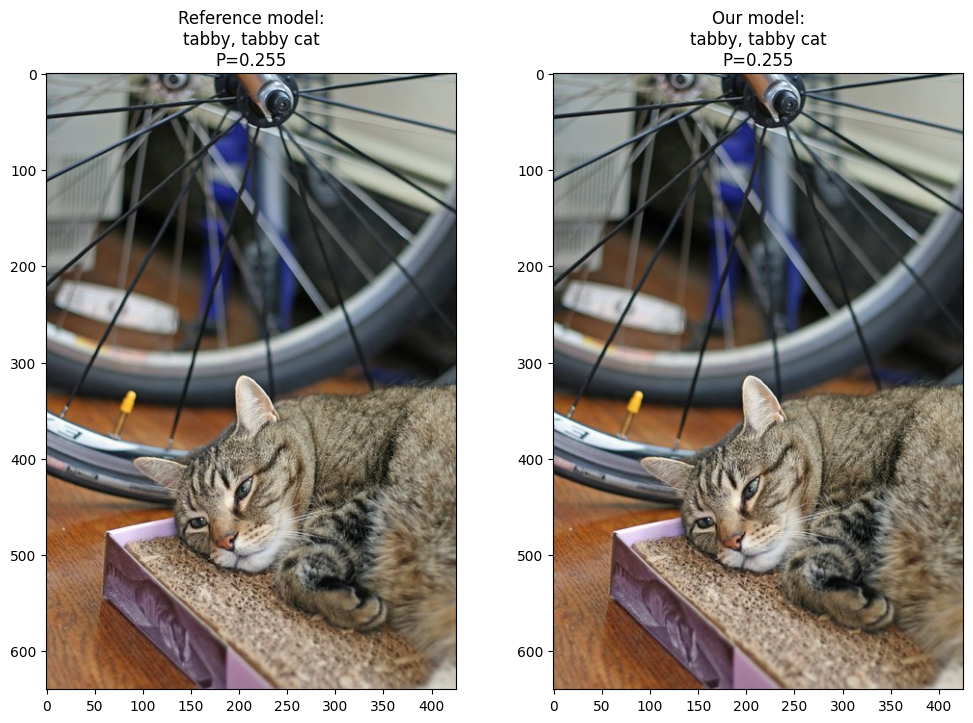

In [8]:
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor
from PIL import Image
import requests

url = "https://farm2.staticflickr.com/1152/1151216944_1525126615_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="np")
outputs = tf_model(**inputs)
logits = outputs.logits


model.eval()
x = jnp.transpose(inputs["pixel_values"], axes=(0, 2, 3, 1))
output = model(x)

# Model predicts one of the 1000 ImageNet classes.
ref_class_idx = logits.argmax(-1).item()
pred_class_idx = output.argmax(-1).item()
assert jnp.abs(logits[0, :] - output[0, :]).max() < 0.1

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].set_title(
    f"Reference model:\n{tf_model.config.id2label[ref_class_idx]}\nP={nnx.softmax(logits, axis=-1)[0, ref_class_idx]:.3f}"
)
axs[0].imshow(image)
axs[1].set_title(
    f"Our model:\n{tf_model.config.id2label[pred_class_idx]}\nP={nnx.softmax(output, axis=-1)[0, pred_class_idx]:.3f}"
)
axs[1].imshow(image)

In [9]:
model.classifier = nnx.Linear(model.classifier.in_features, 20, rngs=nnx.Rngs(0))

x = jnp.ones((4, 224, 224, 3))
y = model(x)
print("Predictions shape: ", y.shape)

Predictions shape:  (4, 20)


## Food 101 dataset

In this section, we'll prepare the dataset and train the ViT model. The dataset is [Food 101](https://huggingface.co/datasets/ethz/food101), which consists of 101 food categories with 101,000 images.

In our example, each class will have 250 test set images and 750 training set images. The training images won't be cleaned and will contain some amount of noise (on purpose), mostly in the form of intense colors and sometimes wrong labels. All images are rescaled to have a maximum side length of 512 pixels.

Let's download the dataset from [HuggingFace Datasets](https://huggingface.co/docs/datasets/) and select 20 classes to reduce the dataset size and the model training time. We'll use [TorchVision](https://pytorch.org/vision) to transform input images and [`grain`](https://github.com/google/grain/) for efficient data loading.

In [10]:
! pip install -q datasets

/usr/local/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
from datasets import load_dataset

# Select first 20 classes to reduce the dataset size and the training time.
train_size = 20 * 750
val_size = 20 * 250

train_dataset = load_dataset("food101", split=f"train[:{train_size}]")
val_dataset = load_dataset("food101", split=f"validation[:{val_size}]")

# Create labels mapping where we map current labels between 0 and 19.
labels_mapping = {}
index = 0
for i in range(0, len(val_dataset), 250):
    label = val_dataset[i]["label"]
    if label not in labels_mapping:
        labels_mapping[label] = index
        index += 1

inv_labels_mapping = {v: k for k, v in labels_mapping.items()}

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Generating validation split: 100%|██████████| 25250/25250 [00:01<00:00, 15824.47 examples/s]


Training dataset size: 15000
Validation dataset size: 5000


In [12]:
import matplotlib.pyplot as plt


def display_datapoints(*datapoints, tag="", names_map=None):
    num_samples = len(datapoints)

    fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
    for i, datapoint in enumerate(datapoints):
        if isinstance(datapoint, dict):
            img, label = datapoint["image"], datapoint["label"]
        else:
            img, label = datapoint

        if hasattr(img, "dtype") and img.dtype in (np.float32, ):
            img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

        label_str = f" ({names_map[label]})" if names_map is not None else ""
        axs[i].set_title(f"{tag}Label: {label}{label_str}")
        axs[i].imshow(img)

Visualize a few samples from the training and test sets:

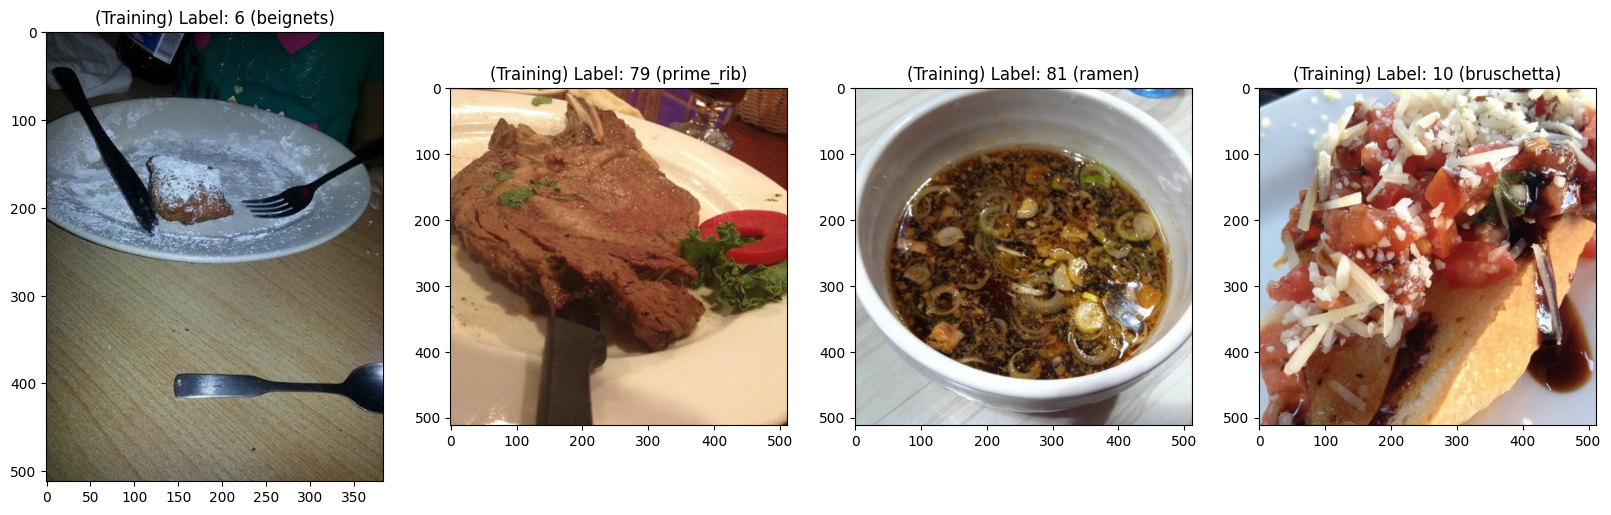

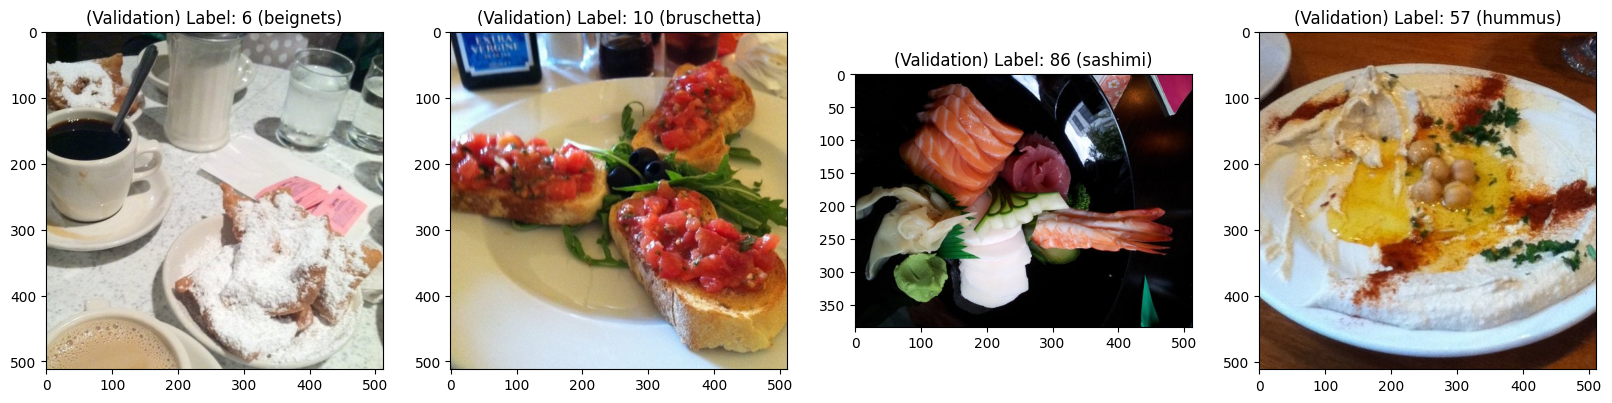

In [13]:
display_datapoints(
    train_dataset[0], train_dataset[1000], train_dataset[2000], train_dataset[3000],
    tag="(Training) ",
    names_map=train_dataset.features["label"].names
)

display_datapoints(
    val_dataset[0], val_dataset[1000], val_dataset[2000], val_dataset[-1],
    tag="(Validation) ",
    names_map=val_dataset.features["label"].names
)

We need to define training and test set image preprocessing helper functions. Training image transformations will also contain random augmentations to prevent overfitting and make the trained model more robust.

In [14]:
import numpy as np
from torchvision.transforms import v2 as T


img_size = 224


def to_np_array(pil_image):
  return np.asarray(pil_image.convert("RGB"))


def normalize(image):
    # Image preprocessing matches the one of pretrained ViT
    mean = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    std = np.array([0.5, 0.5, 0.5], dtype=np.float32)
    image = image.astype(np.float32) / 255.0
    return (image - mean) / std


tv_train_transforms = T.Compose([
    T.RandomResizedCrop((img_size, img_size), scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.2, 0.2, 0.2),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


tv_test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.Lambda(to_np_array),
    T.Lambda(normalize),
])


def get_transform(fn):
    def wrapper(batch):
        batch["image"] = [
            fn(pil_image) for pil_image in batch["image"]
        ]
        # map label index between 0 - 19
        batch["label"] = [
            labels_mapping[label] for label in batch["label"]
        ]
        return batch
    return wrapper


train_transforms = get_transform(tv_train_transforms)
val_transforms = get_transform(tv_test_transforms)

train_dataset = train_dataset.with_transform(train_transforms)
val_dataset = val_dataset.with_transform(val_transforms)

In [15]:
import grain.python as grain


seed = 12
train_batch_size = 32
val_batch_size = 2 * train_batch_size


# Create an `grain.IndexSampler` with no sharding for single-device computations.
train_sampler = grain.IndexSampler(
    len(train_dataset),  # The total number of samples in the data source.
    shuffle=True,            # Shuffle the data to randomize the order.of samples
    seed=seed,               # Set a seed for reproducibility.
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,            # Iterate over the dataset for one epoch.
)

val_sampler = grain.IndexSampler(
    len(val_dataset),  # The total number of samples in the data source.
    shuffle=False,         # Do not shuffle the data.
    seed=seed,             # Set a seed for reproducibility.
    shard_options=grain.NoSharding(),  # No sharding since this is a single-device setup.
    num_epochs=1,          # Iterate over the dataset for one epoch.
)


train_loader = grain.DataLoader(
    data_source=train_dataset,
    sampler=train_sampler,                 # A sampler to determine how to access the data.
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among.
    worker_buffer_size=2,                  # Count of output batches to produce in advance per worker.
    operations=[
        grain.Batch(train_batch_size, drop_remainder=True),
    ]
)

# Test (validation) dataset `grain.DataLoader`.
val_loader = grain.DataLoader(
    data_source=val_dataset,
    sampler=val_sampler,                   # A sampler to determine how to access the data.
    worker_count=4,                        # Number of child processes launched to parallelize the transformations among.
    worker_buffer_size=2,
    operations=[
        grain.Batch(val_batch_size),
    ]
)

Let's visualize the training and test set batches:

In [16]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [17]:
print("Training batch info:", train_batch["image"].shape, train_batch["image"].dtype, train_batch["label"].shape, train_batch["label"].dtype)
print("Validation batch info:", val_batch["image"].shape, val_batch["image"].dtype, val_batch["label"].shape, val_batch["label"].dtype)

Training batch info: (32, 224, 224, 3) float32 (32,) int64
Validation batch info: (64, 224, 224, 3) float32 (64,) int64


/tmp/ipykernel_10/2669850957.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)


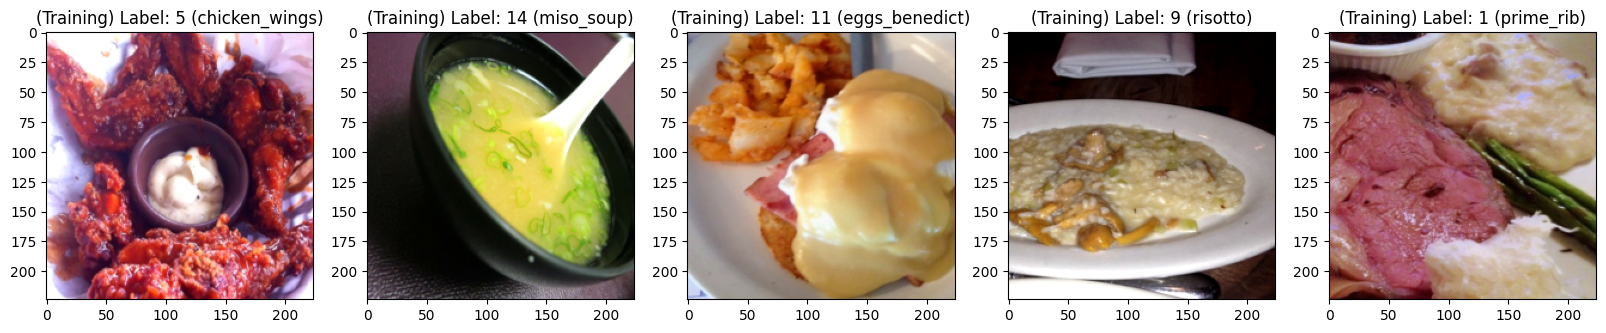

In [18]:
display_datapoints(
    *[(train_batch["image"][i], train_batch["label"][i]) for i in range(5)],
    tag="(Training) ",
    names_map={k: train_dataset.features["label"].names[v] for k, v in inv_labels_mapping.items()}
)

In [19]:
display_datapoints(
    *[(val_batch["image"][i], val_batch["label"][i]) for i in range(5)],
    tag="(Validation) ",
    names_map={k: val_dataset.features["label"].names[v] for k, v in inv_labels_mapping.items()}
)

/tmp/ipykernel_10/2669850957.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)


## Defining the optimizier, the loss function, training/test steps, and metrics

In this section, we'll define the optimizer, the loss function, the training and test step functions, and then begin training the model.

First, initiliaze the learning rate and the SGD optimizer with `optax`, using `optax.sgd` and `flax.nnx.Optimizer`:

In [20]:
num_epochs = 3
learning_rate = 0.001
momentum = 0.8
total_steps = len(train_dataset) // train_batch_size

lr_schedule = optax.linear_schedule(learning_rate, 0.0, num_epochs * total_steps)

iterate_subsample = np.linspace(0, num_epochs * total_steps, 100)
plt.plot(
    np.linspace(0, num_epochs, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, num_epochs))
plt.show()


optimizer = nnx.Optimizer(model, optax.sgd(lr_schedule, momentum, nesterov=True))

Define a loss function with `optax.softmax_cross_entropy_with_integer_labels`:

In [21]:
def compute_losses_and_logits(model: nnx.Module, images: jax.Array, labels: jax.Array):
    logits = model(images)

    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=labels
    ).mean()
    return loss, logits

Set up the train and test steps (with `flax.nnx.jit` and `flax.nnx.value_and_grad`:

In [22]:
@nnx.jit
def train_step(
    model: nnx.Module, optimizer: nnx.Optimizer, batch: dict[str, np.ndarray]
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)

    grad_fn = nnx.value_and_grad(compute_losses_and_logits, has_aux=True)
    (loss, logits), grads = grad_fn(model, images, labels)

    optimizer.update(grads)  # In-place updates.

    return loss


@nnx.jit
def eval_step(
    model: nnx.Module, batch: dict[str, np.ndarray], eval_metrics: nnx.MultiMetric
):
    # Convert np.ndarray to jax.Array on GPU
    images = jnp.array(batch["image"])
    labels = jnp.array(batch["label"], dtype=jnp.int32)
    loss, logits = compute_losses_and_logits(model, images, labels)

    eval_metrics.update(
        loss=loss,
        logits=logits,
        labels=labels,
    )

Instantiae the metrics function with `flax.nnx.MultiMetric`:

In [23]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)


train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [24]:
import tqdm
from time import time

bar_format = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"


def train_one_epoch(epoch):
    model.train()  # Set model to the training mode: e.g. update batch statistics

    for i, batch in enumerate(train_loader):
        
        a = time()
        loss = train_step(model, optimizer, batch)
        b = time()
        
        train_metrics_history["train_loss"].append(loss.item())

        if i%5 == 0:
            print(f"--- Batch: {i}, Loss: {loss.item():.3f}, Time (for each step): {b-a:.3f}s")



def evaluate_model(epoch):
    # Computes the metrics on the training and test sets after each training epoch.
    model.eval()  # Sets model to evaluation model: e.g. use stored batch statistics.

    eval_metrics.reset()  # Reset the eval metrics
    for val_batch in val_loader:
        eval_step(model, val_batch, eval_metrics)

    for metric, value in eval_metrics.compute().items():
        eval_metrics_history[f'val_{metric}'].append(value)

    print(f"[val] epoch: {epoch + 1}/{num_epochs}")
    print(f"- total loss: {eval_metrics_history['val_loss'][-1]:0.4f}")
    print(f"- Accuracy: {eval_metrics_history['val_accuracy'][-1]:0.4f}")

## Training the model

Begin training the model:

In [25]:
%%time

for epoch in range(num_epochs):
    print(f"- Epoch: {epoch+1}")
    train_one_epoch(epoch)
    evaluate_model(epoch)

- Epoch: 1
--- Batch: 0, Loss: 3.821, Time (for each step): 24.459s
--- Batch: 5, Loss: 3.289, Time (for each step): 0.030s
--- Batch: 10, Loss: 3.121, Time (for each step): 0.034s
--- Batch: 15, Loss: 2.884, Time (for each step): 0.032s
--- Batch: 20, Loss: 2.555, Time (for each step): 0.035s
--- Batch: 25, Loss: 2.376, Time (for each step): 0.033s
--- Batch: 30, Loss: 2.238, Time (for each step): 0.034s
--- Batch: 35, Loss: 1.960, Time (for each step): 0.035s
--- Batch: 40, Loss: 1.791, Time (for each step): 0.031s
--- Batch: 45, Loss: 1.914, Time (for each step): 0.033s
--- Batch: 50, Loss: 1.645, Time (for each step): 0.042s
--- Batch: 55, Loss: 1.626, Time (for each step): 0.038s
--- Batch: 60, Loss: 1.398, Time (for each step): 0.033s
--- Batch: 65, Loss: 1.371, Time (for each step): 0.041s
--- Batch: 70, Loss: 1.392, Time (for each step): 0.038s
--- Batch: 75, Loss: 1.387, Time (for each step): 0.036s
--- Batch: 80, Loss: 0.971, Time (for each step): 0.042s
--- Batch: 85, Loss: 

/usr/local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 1/3
- total loss: 0.2409
- Accuracy: 0.9316
- Epoch: 2
--- Batch: 0, Loss: 0.105, Time (for each step): 0.055s
--- Batch: 5, Loss: 0.422, Time (for each step): 0.037s
--- Batch: 10, Loss: 0.188, Time (for each step): 0.046s
--- Batch: 15, Loss: 0.251, Time (for each step): 0.042s
--- Batch: 20, Loss: 0.423, Time (for each step): 0.037s
--- Batch: 25, Loss: 0.134, Time (for each step): 0.035s
--- Batch: 30, Loss: 0.317, Time (for each step): 0.039s
--- Batch: 35, Loss: 0.458, Time (for each step): 0.035s
--- Batch: 40, Loss: 0.292, Time (for each step): 0.037s
--- Batch: 45, Loss: 0.460, Time (for each step): 0.035s
--- Batch: 50, Loss: 0.433, Time (for each step): 0.595s
--- Batch: 55, Loss: 0.165, Time (for each step): 0.034s
--- Batch: 60, Loss: 0.256, Time (for each step): 0.034s
--- Batch: 65, Loss: 0.491, Time (for each step): 0.034s
--- Batch: 70, Loss: 0.428, Time (for each step): 0.036s
--- Batch: 75, Loss: 0.284, Time (for each step): 0.036s
--- Batch: 80, Loss: 0

/usr/local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 2/3
- total loss: 0.1919
- Accuracy: 0.9442
- Epoch: 3
--- Batch: 0, Loss: 0.083, Time (for each step): 0.055s
--- Batch: 5, Loss: 0.324, Time (for each step): 0.037s
--- Batch: 10, Loss: 0.112, Time (for each step): 0.040s
--- Batch: 15, Loss: 0.133, Time (for each step): 0.041s
--- Batch: 20, Loss: 0.366, Time (for each step): 0.037s
--- Batch: 25, Loss: 0.184, Time (for each step): 0.047s
--- Batch: 30, Loss: 0.219, Time (for each step): 0.032s
--- Batch: 35, Loss: 0.359, Time (for each step): 0.034s
--- Batch: 40, Loss: 0.252, Time (for each step): 0.033s
--- Batch: 45, Loss: 0.287, Time (for each step): 0.032s
--- Batch: 50, Loss: 0.325, Time (for each step): 0.035s
--- Batch: 55, Loss: 0.073, Time (for each step): 0.041s
--- Batch: 60, Loss: 0.192, Time (for each step): 0.031s
--- Batch: 65, Loss: 0.380, Time (for each step): 0.034s
--- Batch: 70, Loss: 0.281, Time (for each step): 0.038s
--- Batch: 75, Loss: 0.217, Time (for each step): 0.036s
--- Batch: 80, Loss: 0

/usr/local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


[val] epoch: 3/3
- total loss: 0.1821
- Accuracy: 0.9464
CPU times: user 3min 9s, sys: 37.4 s, total: 3min 46s
Wall time: 6min 6s


Visualize the collected metrics:

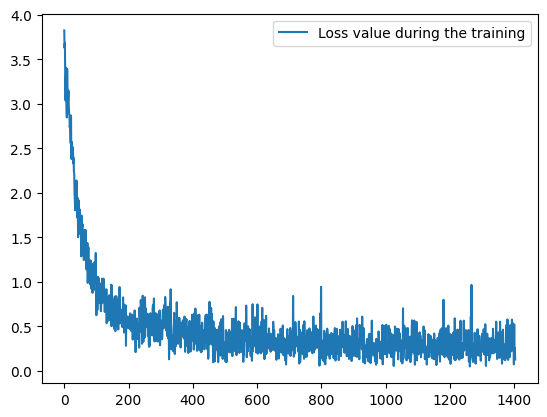

In [26]:
plt.plot(train_metrics_history["train_loss"], label="Loss value during the training")
plt.legend()

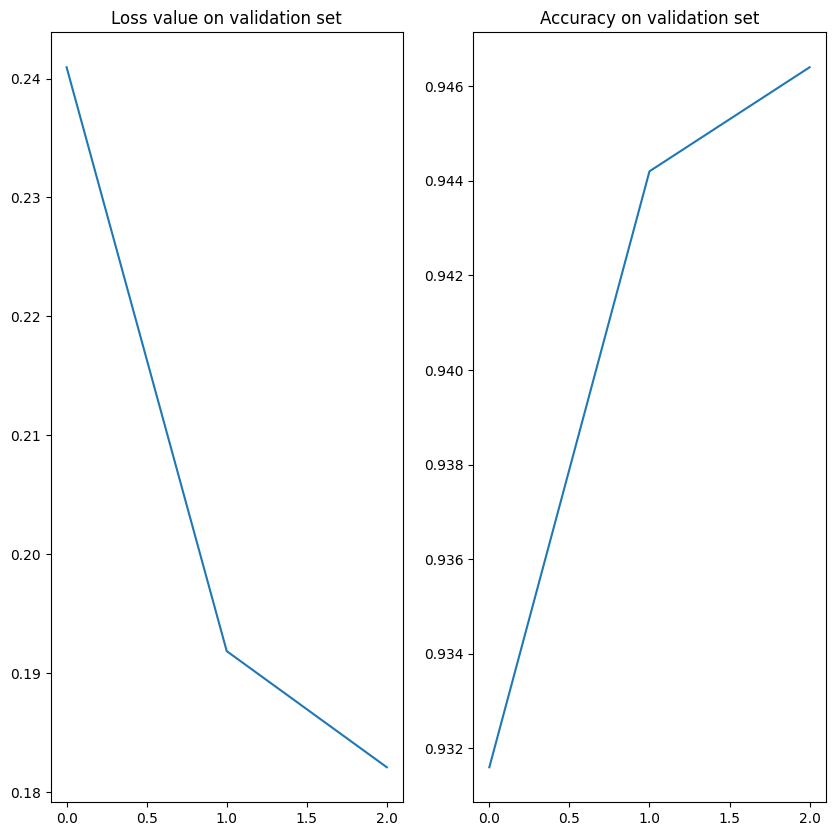

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].set_title("Loss value on validation set")
axs[0].plot(eval_metrics_history["val_loss"])
axs[1].set_title("Accuracy on validation set")
axs[1].plot(eval_metrics_history["val_accuracy"])

Check the model's predictions on the test data:

In [28]:
test_indices = [1, 250, 500, 750, 1000]

test_images = jnp.array([val_dataset[i]["image"] for i in test_indices])
expected_labels = [val_dataset[i]["label"] for i in test_indices]

model.eval()
preds = model(test_images)

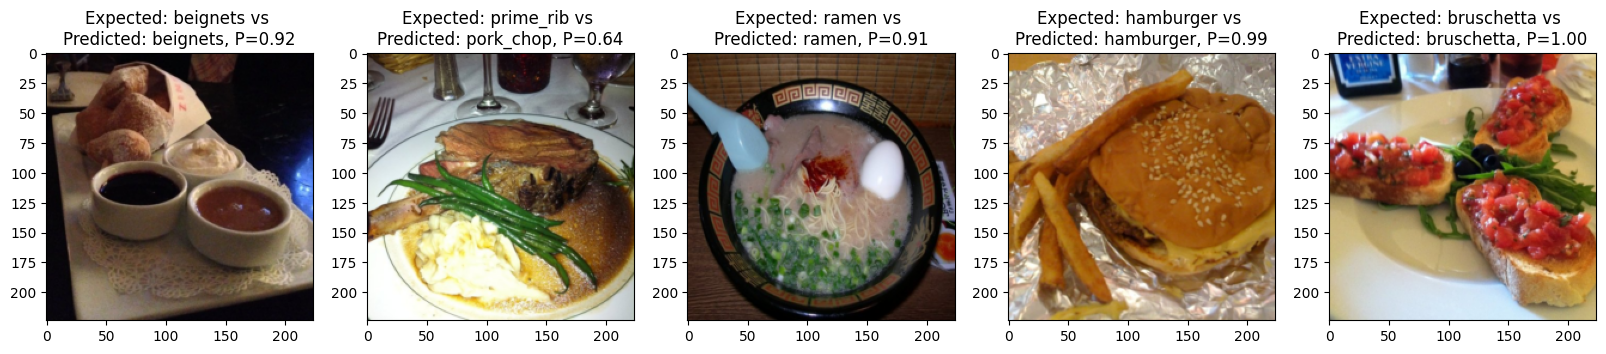

In [29]:
num_samples = len(test_indices)
names_map = train_dataset.features["label"].names

probas = nnx.softmax(preds, axis=1)
pred_labels = probas.argmax(axis=1)


fig, axs = plt.subplots(1, num_samples, figsize=(20, 10))
for i in range(num_samples):
    img, expected_label = test_images[i], expected_labels[i]

    pred_label = pred_labels[i].item()
    proba = probas[i, pred_label].item()
    if img.dtype in (np.float32, ):
        img = ((img - img.min()) / (img.max() - img.min()) * 255.0).astype(np.uint8)

    expected_label_str = names_map[inv_labels_mapping[expected_label]]
    pred_label_str = names_map[inv_labels_mapping[pred_label]]
    axs[i].set_title(f"Expected: {expected_label_str} vs \nPredicted: {pred_label_str}, P={proba:.2f}")
    axs[i].imshow(img)